<a href="https://colab.research.google.com/github/reshalfahsi/swinging-up-acrobot/blob/master/Swinging_Up_Acrobot_with_n_Step_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Swinging Up Acrobot with n-Step Q-Learning**

## **Important Libraries**

### **Install**

In [1]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.10 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [43]:
!uv pip install -q --no-cache-dir --system swig lightning

In [3]:
!uv pip install -q --no-cache-dir --system gymnasium[classic-control]

### **Import**

In [44]:
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

import gymnasium as gym

from google.colab.patches import cv2_imshow

from collections import deque
import matplotlib.animation
from IPython.display import Image, HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [20]:
ACTION_SPACE = [
    0, # apply -1 torque to the actuated joint
    1, # apply 0 torque to the actuated joint
    2, # apply 1 torque to the actuated joint
]


# 0: Cosine of θ₁
# 1: Sine of θ₁
# 2: Cosine of θ₂
# 3: Sine of θ₂
# 4: Angular velocity of θ₁
# 5: Angular velocity of θ₂
OBSERVATION_SPACE = 6


N_STEP = 3                  # Number of steps for TD(n)
GAMMA = 0.99                # Discount factor
EPSILON_START = 1.0         # Initial exploration rate
EPSILON_END = 0.01          # Final exploration rate
EPSILON_DECAY = 0.9996      # Decay rate for exploration rate
LR = 0.001                  # Learning rate
BATCH_SIZE = 64             # Batch size for training
MEMORY_SIZE = 100           # Maximum buffer size of the replay memory
NUM_UPDATE_PER_EPISODE = 9  # Number of updates per episode
NUM_EPISODE = 10201         # Number of episodes for training
TARGET_UPDATE_COND = 144    # Condition of updating the target network
MAXIMUM_STEP = 512          # Maximum number of steps per episode


AcrobotAgent = None
TotalReward = 0

ENVIRONMENT_NAME = "Acrobot-v1"

In [21]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"


BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    "Acrobot_best.ckpt",
)

In [22]:
METRIC_TO_MONITOR = "reward"
METRIC_MODE = "max"

In [23]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1995309294


## **Dataset**

In [24]:
class RLDataset(data.Dataset):
    def __init__(self, rl_agent):
        super().__init__()

        self.env = gym.make(ENVIRONMENT_NAME)
        self.rl_agent = rl_agent
        self.replay_memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        global TotalReward

        TotalReward = 0

        trajectory = list()
        state_batch = list()
        action_batch = list()
        target_batch = list()

        obs, _ = self.env.reset()

        with torch.no_grad():
            for step in range(MAXIMUM_STEP):
                action = self.rl_agent.choose_action(
                    torch.tensor(obs).unsqueeze(0).to(
                        "cuda" if torch.cuda.is_available() else "cpu"
                    ),
                    self.epsilon,
                )
                next_obs, reward, terminated, truncated, _ = self.env.step(
                    action
                )

                # We need to hack the reward!!
                reward = (reward + 0.5) * 2.

                done = terminated or truncated

                trajectory.append((obs, action, reward, next_obs, done))
                obs = next_obs

                TotalReward += reward

                if done:
                    break

        self.replay_memory.append(trajectory)

        for _ in range(BATCH_SIZE):
            episode = random.choice(self.replay_memory)

            T = len(episode)
            t = random.randint(0, T - 1)
            s_t, a_t, _, _, _ = episode[t]

            target = 0.
            discount = 1.
            done = False

            for n in range(N_STEP):
                if t + n >= T:
                    break

                _, _, r, _, d = episode[t + n]
                target += discount * r
                done = d

                if done:
                    break

                discount *= GAMMA

            if not done and t + n + 1 < T:
                s_next = episode[t + n + 1][3]

                with torch.no_grad():
                    s_next = torch.tensor(s_next).unsqueeze(0).to(
                        "cuda" if torch.cuda.is_available() else "cpu"
                    )
                    q_next = self.rl_agent(s_next, target=True).squeeze(
                        0
                    ).max().item()

                target += discount * GAMMA * q_next

            state_batch.append(s_t)
            action_batch.append(a_t)
            target_batch.append(target)

        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

        return torch.tensor(state_batch).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        ), torch.tensor(action_batch).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        ), torch.tensor(target_batch).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

In [25]:
class RLDataModule(L.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.dataset = RLDataset
        self.rl_agent = None

    def prepare_data(self):
        global AcrobotAgent
        self.rl_agent = AcrobotAgent

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = self.dataset(rl_agent=self.rl_agent)

    def train_dataloader(self):
        return data.DataLoader(self.train_dataset, batch_size=BATCH_SIZE)

## **Model**

In [28]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.value_function = nn.Sequential(
            nn.Linear(OBSERVATION_SPACE, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(ACTION_SPACE)),
        )

    def forward(self, x):
        return self.value_function(x)

In [29]:
class AgentModule(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.q_network = QNetwork()
        self.target_q_network = QNetwork()

        self.target_q_network.load_state_dict(self.q_network.state_dict())
        self.target_q_network.eval()

        for param in self.target_q_network.parameters():
            param.requires_grad = False

        self.automatic_optimization = False

        self.reward = list()

    def forward(self, x, target=False):
        if target:
            return self.target_q_network(x)
        else:
            return self.q_network(x)

    def choose_action(self, state, epsilon=EPSILON_END):
        if random.random() < epsilon:
            return random.choice(ACTION_SPACE)
        else:
            with torch.no_grad():
                return torch.argmax(self(state)).item()

    def training_step(self, batch, batch_nb):
        state, action, target = batch

        state = state.squeeze(0)
        action = action.squeeze(0).unsqueeze(1)
        target = target.squeeze(0).unsqueeze(1)

        for _ in range(NUM_UPDATE_PER_EPISODE):
            q_pred = self(state).gather(1, action)
            q_target = target.detach()

            loss = F.mse_loss(q_pred, q_target)

            optimizer = self.optimizers()
            optimizer.zero_grad()
            self.manual_backward(loss)
            optimizer.step()

        self.log("reward", TotalReward, prog_bar=True)
        self.reward.append(TotalReward)

        if self.current_epoch % TARGET_UPDATE_COND == 0:
            self.target_q_network.load_state_dict(self.q_network.state_dict())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.q_network.parameters(), lr=LR)
        return optimizer

    def reward_curve(self):
        filename = f"{EXPERIMENT_DIR}reward_plot.png"
        plt.plot(self.reward, color="g")
        plt.title("Reward Curves")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid()
        plt.savefig(filename)
        plt.clf()
        img = cv2.imread(filename)
        cv2_imshow(img)

## **Training**

In [30]:
trainer = None

def _train_loop():
    global AcrobotAgent, trainer

    seed_everything(SEED, workers=True)

    AcrobotAgent = AgentModule()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=os.path.join(EXPERIMENT_DIR, "model"),
        mode=METRIC_MODE,
        filename="Acrobot_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=NUM_EPISODE,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )

    trainer.fit(AcrobotAgent, ckpt_path=ckpt_path, datamodule=RLDataModule())

_train_loop()

INFO: Seed set to 1995309294
INFO:lightning.fabric.utilities.seed:Seed set to 1995309294
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name             | Type     | Params | Mode 
------------------------------------------------------
0 | q_network        | QNetwork | 17.2 K | train
1 | target_q_network | QNetwork | 17.2 K | eval 
------------------------------------------------------
17.2 K    Trainable params
17.2 K    Non-trainable params
34.4 K    Total params
0.138     Total estimated model params size (MB)
9      

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10201` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10201` reached.


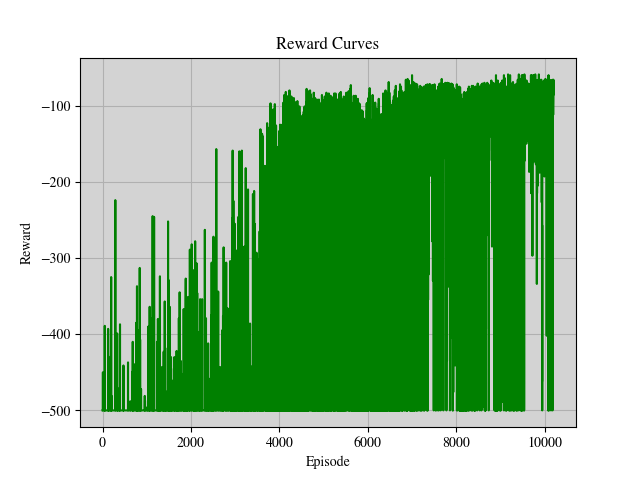

<Figure size 640x480 with 0 Axes>

In [31]:
trainer.strategy._lightning_module.reward_curve()

## **Inference**

In [45]:
def animate_frames(frames, output):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi=120)

    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(
        frames[0], aspect="auto", animated=True, interpolation="bilinear"
    )
    animate = lambda i: patch.set_data(frames[i])

    ani = matplotlib.animation.FuncAnimation(
        fig, animate, frames=len(frames), interval=50
    )

    plt.close()
    if output == "html":
        return HTML(ani.to_jshtml())
    elif output == "gif":
        filename = f"{EXPERIMENT_DIR}inference.gif"
        ani.save(filename, writer="imagemagick", fps=60)
        with open(filename, "rb") as f:
            display(Image(data=f.read(), format="gif"))

In [46]:
def animate_agent(env, agent, output, max_steps=MAXIMUM_STEP):
    obs, _ = env.reset(seed=SEED)
    total_reward = 0

    frames = deque()
    frame = env.render()
    frame = cv2.putText(
        frame,
        "Step: 0 Action : 0 Reward: 0 Total"
        ":"
        f"{int(total_reward)}",
        (10, 20),
        cv2.FONT_HERSHEY_COMPLEX_SMALL,
        0.75,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )
    frames.append(frame)

    for step in range(max_steps):
        obs = torch.tensor(obs).unsqueeze(0).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        action = agent.choose_action(obs)
        obs, reward, terminated, truncated, _ = env.step(action)

        # Reward Hack
        reward = (reward + 0.5) * 2.
        total_reward += reward

        done = terminated or truncated
        frame = env.render()
        frame = cv2.putText(
            frame,
            f"Step: {step + 1} Action : {action} Reward: {int(reward)} "
            f"Total: {int(total_reward)}",
            (10, 20),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            0.75,
            (0, 0, 0),
            1,
            cv2.LINE_AA,
        )
        frames.append(frame)
        if done:
            break

    # Additional frames
    for _ in range(100):
        frames.append(frame)

    return animate_frames(frames, output)

In [47]:
AcrobotEnv = gym.make(ENVIRONMENT_NAME, render_mode="rgb_array")

AcrobotAgent = AgentModule.load_from_checkpoint(BEST_MODEL_PATH)
if torch.cuda.is_available():
    AcrobotAgent = AcrobotAgent.cuda()
AcrobotAgent.eval()

AgentModule(
  (q_network): QNetwork(
    (value_function): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (target_q_network): QNetwork(
    (value_function): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [48]:
animate_agent(AcrobotEnv, AcrobotAgent, output="html")

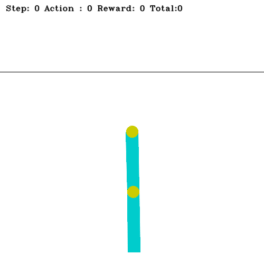

In [49]:
animate_agent(AcrobotEnv, AcrobotAgent, output="gif")